In [10]:
!nvidia-smi

Thu Dec 21 08:33:10 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   26C    P8    11W /  70W |      2MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [11]:
import torch

In [12]:
# pip install timm==0.6.12

In [13]:
# pip install ultralytics

In [14]:
import sys
sys.path.append('../')  # 상위 디렉토리 추가

In [15]:
import cv2
import matplotlib.pyplot as plt
import torch
import numpy as np
from PIL import Image
from ultralytics import YOLO
from zoedepth.utils.misc import colorize
import torch.nn as nn
%matplotlib inline

In [16]:
# Load YOLO model for vehicle detection
coco_model = YOLO('yolov8m.pt')
vehicles = [1, 2, 3, 5, 7]  # Coco dataset class nums for vehicles
traffic_light = [9]

In [17]:
torch.hub.help("intel-isl/MiDaS", "DPT_BEiT_L_384", force_reload=True)  # Triggers fresh download of MiDaS repo

Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to /home/ubuntu/.cache/torch/hub/master.zip


' # This docstring shows up in hub.help()\n    MiDaS DPT_BEiT_L_384 model for monocular depth estimation\n    pretrained (bool): load pretrained weights into model\n    '

In [18]:
repo = "isl-org/ZoeDepth"
# Zoe_N
# model_zoe_n = torch.hub.load(repo, "ZoeD_N", pretrained=True)

# Zoe_K
# model_zoe_k = torch.hub.load(repo, "ZoeD_K", pretrained=True)

# Zoe_NK
model_zoe_nk = torch.hub.load(repo, "ZoeD_NK", pretrained=True)

Using cache found in /home/ubuntu/.cache/torch/hub/isl-org_ZoeDepth_main
Using cache found in /home/ubuntu/.cache/torch/hub/intel-isl_MiDaS_master
/home/ubuntu/anaconda3/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343967769/work/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


img_size [384, 512]
Params passed to Resize transform:
	width:  512
	height:  384
	resize_target:  True
	keep_aspect_ratio:  True
	ensure_multiple_of:  32
	resize_method:  minimal
Using pretrained resource url::https://github.com/isl-org/ZoeDepth/releases/download/v1.0/ZoeD_M12_NK.pt
Loaded successfully


In [19]:
# # Load depth estimation model
# repo = "isl-org/ZoeDepth"
# model_zoe_nk = torch.hub.load(repo, "ZoeD_NK", pretrained=False)
# pretrained_dict = torch.hub.load_state_dict_from_url('https://github.com/isl-org/ZoeDepth/releases/download/v1.0/ZoeD_M12_NK.pt', map_location='cpu')
# model_zoe_nk.load_state_dict(pretrained_dict['model'], strict=False)
# for b in model_zoe_nk.core.core.pretrained.model.blocks:
#     b.drop_path = nn.Identity()


In [20]:
zoe = model_zoe_nk.to('cuda')

In [21]:
# Function to convert OpenCV image to PIL image
def cv2_to_pil(cv2_image):
    cv2_image_rgb = cv2.cvtColor(cv2_image, cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(cv2_image_rgb)
    return pil_image

def get_depth_estimation(frame):
    # Get raw depth data (in meters)
    raw_depth = zoe.infer_pil(frame, pad_input=False, output_type="numpy")

    # Colorize for visualization
    colored_depth = colorize(raw_depth)
    return raw_depth, colored_depth


# Image

In [22]:
image_list = [
    # "/content/Men-in-Black/sample/SeSAC_with_distance_5.83m.jpeg",
    # "/content/Men-in-Black/sample/SeSAC_with_distance_5.88.jpeg",
    # "/content/Men-in-Black/sample/SeSAC_with_distance_5.94m.jpeg",
    "/content/Men-in-Black/sample/SeSAC_without_distance_6m.jpeg",
    "/content/Men-in-Black/sample/SeSAC_without_distance_on_car_3.5m.jpeg",
    "/content/Men-in-Black/sample/SeSAC_without_distance_on_car_6.99m.jpeg"
]


0: 480x640 1 car, 63.4ms
Speed: 8.6ms preprocess, 63.4ms inference, 10.9ms postprocess per image at shape (1, 3, 480, 640)


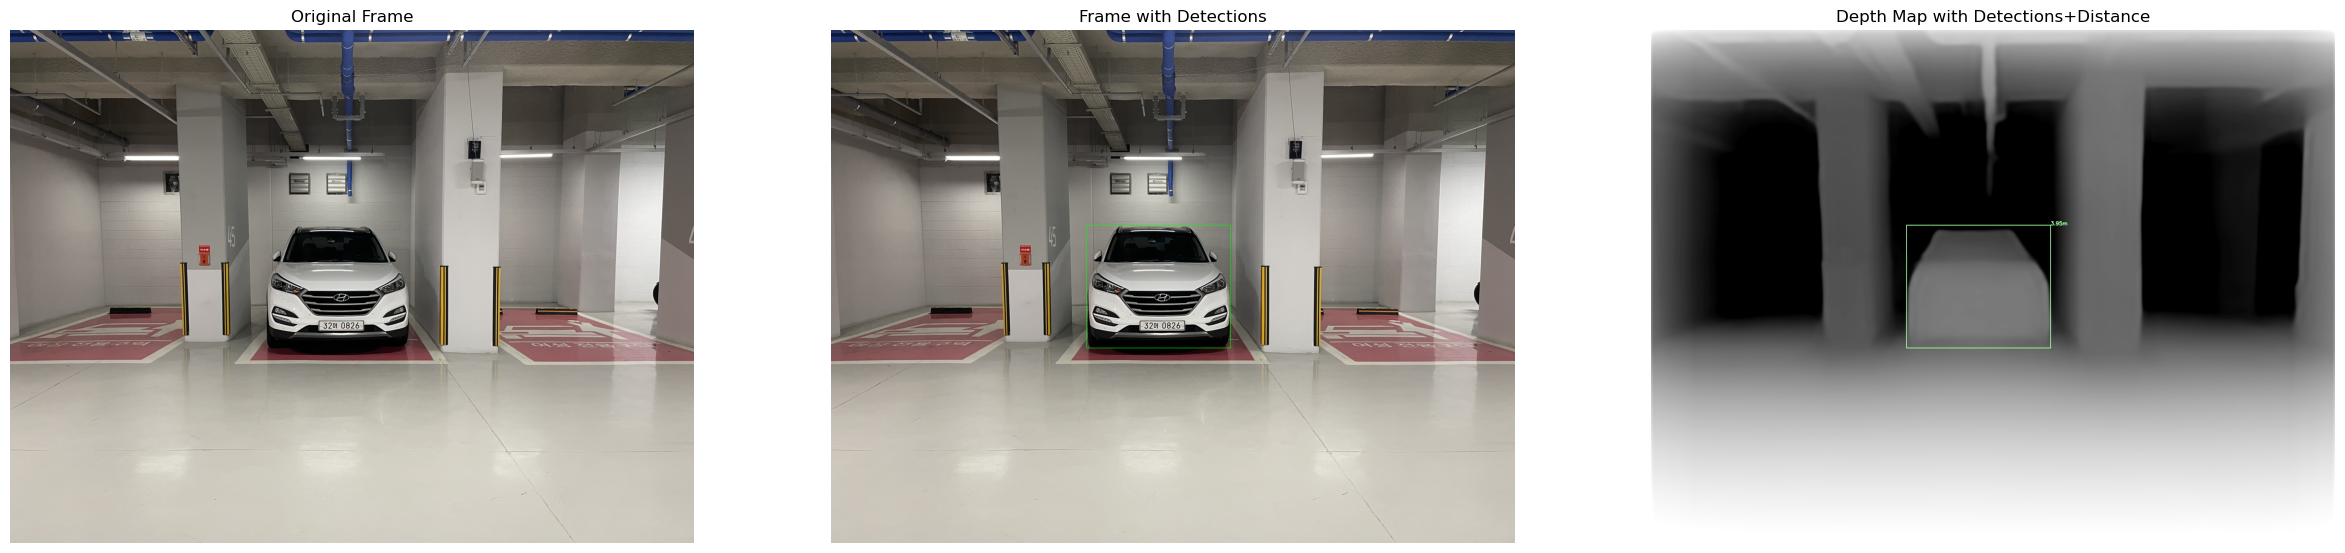


0: 480x640 3 cars, 1 truck, 30.0ms
Speed: 2.5ms preprocess, 30.0ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


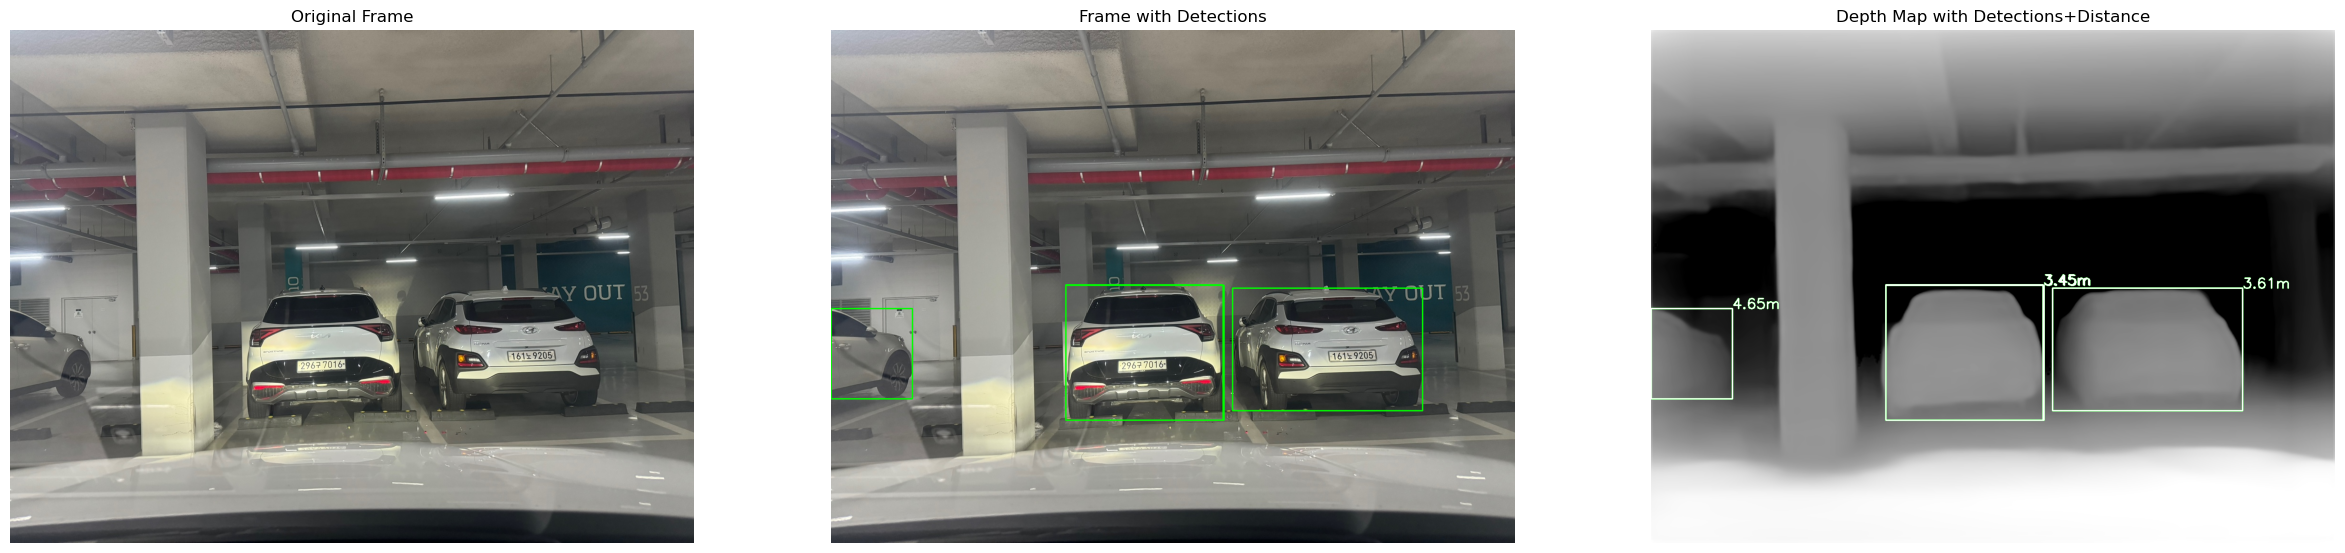


0: 480x640 3 cars, 13.1ms
Speed: 2.5ms preprocess, 13.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


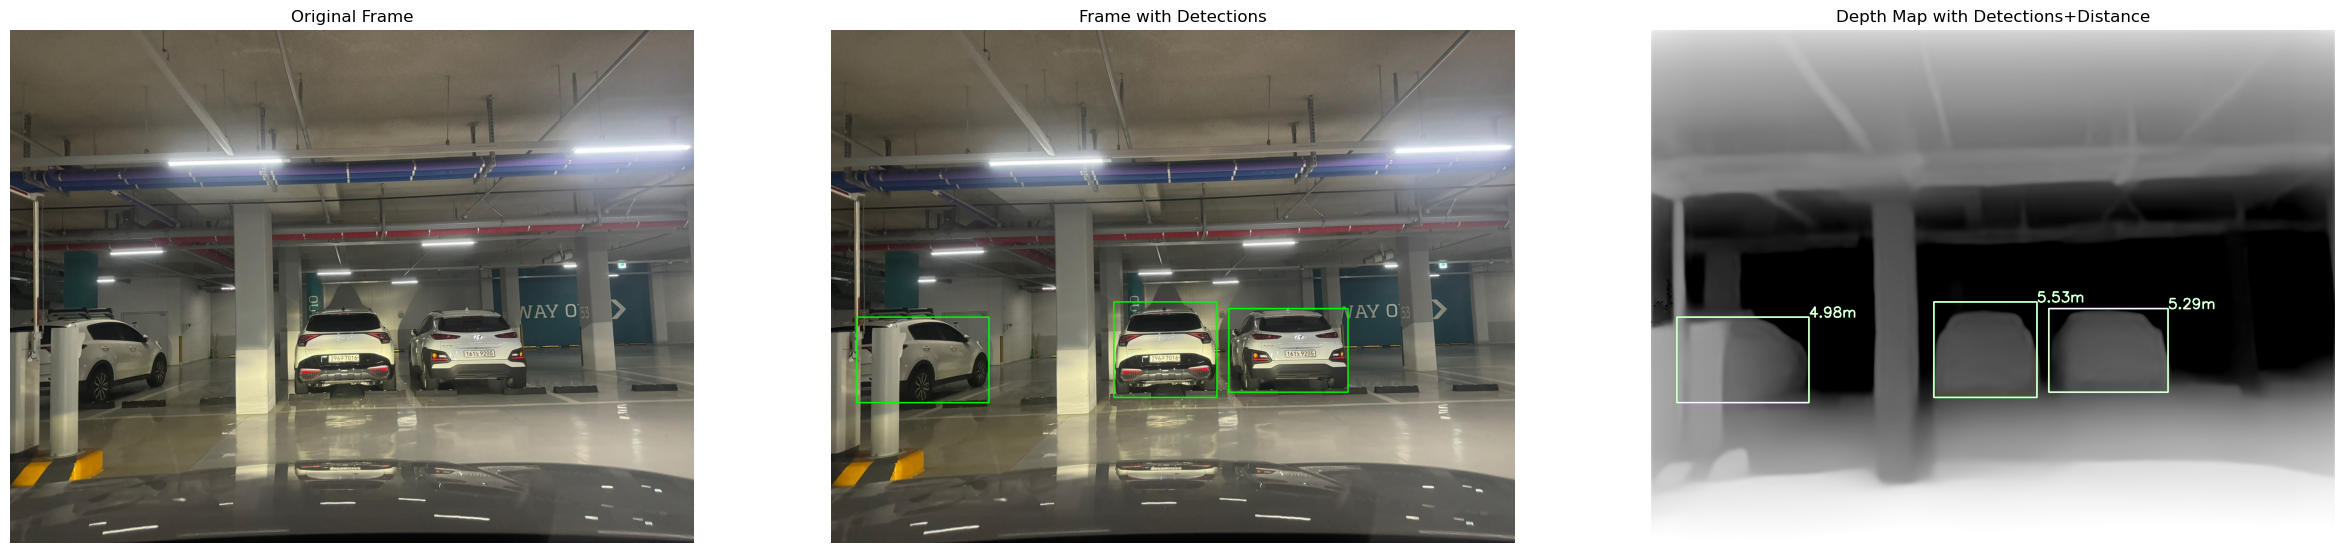

In [23]:
for image_path in image_list:
    frame = cv2.imread(image_path)
    
    if frame is None:
        continue

    detections = coco_model(frame)[0]
    frame_with_detections = frame.copy()
    raw_depth, depth_image = get_depth_estimation(cv2_to_pil(frame))
    depth_image_with_detections = depth_image.copy()

    for detection in detections.boxes.data.tolist():
        x1, y1, x2, y2, score, class_id = detection
        if int(class_id) in vehicles or int(class_id) in traffic_light:
            center_x = int((x1 + x2) / 2)
            center_y = int((y1 + y2) / 2)
            depth_value = raw_depth[center_y, center_x]
            if isinstance(depth_value, np.ndarray):
                depth_value = np.mean(depth_value)
            cv2.rectangle(frame_with_detections, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
            cv2.rectangle(depth_image_with_detections, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
            cv2.putText(depth_image_with_detections, f"{depth_value:.2f}m", (int(x2), int(y1)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame_with_detections_rgb = cv2.cvtColor(frame_with_detections, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(30, 15))
    for i, (img, title) in enumerate(zip([frame_rgb, frame_with_detections_rgb, depth_image_with_detections], ["Original Frame", "Frame with Detections", "Depth Map with Detections+Distance"])):
        plt.subplot(1, 3, i+1)
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')
    plt.show()


# Video

In [ ]:
# Load video
# video_path = '/content/Men-in-Black/sample_videos/test_input_video(5sec)(1920x1080_30FPS).mp4'
video_path = '/content/Men-in-Black/sample/SeSAC_forward_6.99m_to_1.46m.mp4'
cap = cv2.VideoCapture(video_path)

In [ ]:
cap.isOpened()

In [ ]:
count = 0
while count<20:
    count+=1
    ret, frame = cap.read()
    if not ret:
        break

    # # Detect objects in the frame
    # detections = coco_model(frame)[0]
    # frame_with_detections = frame.copy()
    # depth_image = get_depth_estimation(cv2_to_pil(frame))

    # Detect objects in the frame
    detections = coco_model(frame)[0]
    frame_with_detections = frame.copy()
    raw_depth, depth_image = get_depth_estimation(cv2_to_pil(frame))
    depth_image_with_detections = depth_image.copy()


    # Process each detection
    for detection in detections.boxes.data.tolist():
        x1, y1, x2, y2, score, class_id = detection
        if int(class_id) in vehicles or int(class_id) in traffic_light:
            # Calculate center of the bounding box (you can use this if needed)
            center_x = int((x1 + x2) / 2)
            center_y = int((y1 + y2) / 2)
    
            # Get depth value at the center from raw depth data
            depth_value = raw_depth[center_y, center_x]
    
            # Ensure depth_value is a single float value
            if isinstance(depth_value, np.ndarray):
                depth_value = np.mean(depth_value)
    
            # Draw bounding boxes on both images
            cv2.rectangle(frame_with_detections, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
            cv2.rectangle(depth_image_with_detections, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
    
            # Text position (top right corner of the bounding box)
            text_position = (int(x2), int(y1))
    
            # Increase font size
            font_scale = 1
    
            # Write depth value on the depth image
            cv2.putText(depth_image_with_detections, f"{depth_value:.2f}m", text_position, cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 255, 0), 2)

    # Convert frames for displaying
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame_with_detections_rgb = cv2.cvtColor(frame_with_detections, cv2.COLOR_BGR2RGB)

    # Display the images using Matplotlib
    plt.figure(figsize=(30, 15))
    for i, (img, title) in enumerate(zip([frame_rgb, frame_with_detections_rgb, depth_image_with_detections], 
                                         ["Original Frame", "Frame with Detections", "Depth Map with Detections+Distance"])):
        plt.subplot(1, 3, i+1)
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')
    plt.show()

    # Break the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

In [7]:
import sys

In [9]:
sys.executable

'/home/ubuntu/anaconda3/bin/python'

In [6]:
gr.__version__

'4.11.0'

In [5]:
import gradio as gr
def update(name):
    return f"Welcome to Gradio, {name}!"

with gr.Blocks(css=css) as demo:
    gr.Markdown(title)
    gr.Markdown(description)
    with gr.Tab("Image Depth Prediction"):
        create_depth_pred_demo(depth_model)
    with gr.Tab("Video Depth Prediction"):
        create_depth_pred_demo_video(depth_model)
    with gr.Tab("Image to 3D"):
        create_im_to_3d_demo(depth_model)
    with gr.Tab("360 Panorama to 3D"):
        create_pano_to_3d_demo(depth_model)

demo.launch(share=True)

Running on local URL:  http://127.0.0.1:7863
Running on public URL: https://b23129e364c8dc0d63.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [1]:
import gradio as gr
# ... set up Gradio interface ...
iface.launch(server_name='0.0.0.0', server_port=7860)


NameError: name 'iface' is not defined

In [ ]:
iface.launch(server_name='0.0.0.0', server_port=7860, share=True)
